In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import optim
from sklearn.model_selection import train_test_split

In [ ]:
## Reading the csv file
imdb=pd.read_csv('IMDB Dataset.csv')
imdb.head()

In [3]:
imdb.describe()

,length of text
count,50000.00000
mean,1309.67016
std,990.02418
min,32.00000
25%,699.00000
50%,971.00000
75%,1591.00000
max,13704.00000


In [4]:
##Considering only the length of text >2000
newimdb=imdb[imdb['length of text']>2000]

In [5]:
newimdb.count()

review            8415
length of text    8415
sentiment         8415
dtype: int64

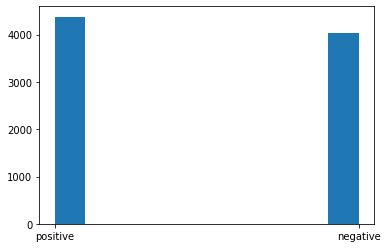

In [6]:
positive=newimdb[newimdb['sentiment']=='positive']
negative=newimdb[newimdb['sentiment']=='negative']
plt.hist(newimdb['sentiment']);

In [7]:
##Removing punctuation and forming "bag of words" with each word and 
##their corresponding occurences in the dataset
from string import punctuation
words_bag={}
punctuation_list=list(punctuation)
maxWordsInReview=0
for review in newimdb['review']:
    review_lower_split=review.lower().split()
    if len(review_lower_split)> maxWordsInReview:
        maxWordsInReview= len(review_lower_split)
    wordlist=[word for word in review_lower_split  if word.isalpha() ]
    for i in wordlist:
        words_bag[i]=words_bag.get(i,0)+1
 

In [8]:
##Top 25K sorted words according to their frequent occurences

top25k_sorted_wordcount=sorted(words_bag.values(),reverse=True)[:25000]
final_word_bag=[k for k in words_bag.keys()   if words_bag[k] in top25k_sorted_wordcount]


In [9]:
##Forming bag of words with the top 25K words
final_word_bag_dict={}
for i in range(1,len(final_word_bag)+1):
    final_word_bag_dict[final_word_bag[i-1]]=i

In [10]:
## Creating an empty matrix X
X=np.zeros(newimdb['review'].count()*(maxWordsInReview)).reshape(newimdb['review'].count(),maxWordsInReview)
X.shape

(8415, 2470)

In [11]:
##Creating matrix X according to the words in each of the  review in the dataset
i=0
for A in newimdb['review']:
    for j,review in enumerate(A.split()):
        review_lower_split=review.lower()
        pos=final_word_bag_dict.get(review_lower_split,0)
        X[i,j]=int(pos)
    i=i+1


In [12]:
#split_dataset into 70% training , 20% test and 10% Validation Dataset
y=[1 if j=='positive' else 0 for j in newimdb['sentiment']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=10)
print(len(X_train),  len(X_test),len(X_valid))


5385 1683 1347


In [13]:
##Converting the numpy array into tensor
x_train, x_valid,x_test  = map( torch.LongTensor, (X_train, X_valid,X_test))
y_train,  y_valid,y_test = map( torch.FloatTensor, ( y_train,y_valid,y_test))
# train_data, valid_data, test_y,valid_y = train_test_split(X_train, y_train, test_size=0.10, random_state=10)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
##Defining the model
class Linearmodel(nn.Module):
    def __init__(self, vocabulary_size, embed_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocabulary_size, embed_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embed_dim, output_dim)
        
    def forward(self, text):
        
        # Takes 64 reviews, each column represents a single review
        # Each word in the review is transformed to 100 dimention by using glove
        # So, input [x,64] -> [x,64,100]

        embedded = self.embedding(text)

        # Changes dimension ie input with 3 dim,0 becomes 1st dim, 1 becomes 0 dim, 2 remains same  [x,64,100]->[64,x,100]
        embedded = embedded.permute(1, 0, 2)
        
        #average x into 1 ie [x,64,100] -> [64,100]
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 

        # transform y=Ax+b ie  y=1 0r 0, x=[64*100] , A is weight matrix adjusted b is bias        
        return self.fc(pooled)

In [16]:
## Creating the model
model = Linearmodel(len(final_word_bag)+1, 100, 1,0)

In [17]:
#Optimizing the Weights and the bias

import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()


In [18]:
##Calculating accuracy of the model
def accuracy(pred, y):

    pred_round = torch.round(torch.sigmoid(pred))
    correct = (pred_round == y).float()  
    acc = correct.sum() / len(correct)
    return acc

In [19]:
##Spliting into batches
batchSize=64
trainBatches=x_train.split(64)
trainYBatches=y_train.split(64)
validXBatches=x_valid.split(64)
validYBatches=y_valid.split(64)

In [20]:
##Defining the train process
def train():
    model.train()
    total_loss = 0
    total_acc = 0
    for i,batch in enumerate(trainBatches):
        permutedBatch=batch.permute(1,0)
        optimizer.zero_grad()
        pred= model(permutedBatch).squeeze(1)
        #print(pred)
        #print(torch.FloatTensor(trainYBatches[i]))
        loss = criterion(pred, trainYBatches[i])
        acc = accuracy(pred,trainYBatches[i])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc.item()
    return (total_loss / len(trainBatches), total_acc / len(trainBatches))   

In [21]:
##Defining Evaluation process
def evaluate():
    total_loss = 0
    total_acc = 0    
    model.eval()
    with torch.no_grad():
        for i,batch in enumerate(validXBatches):
            permutedBatch=batch.permute(1,0)
            pred = model(permutedBatch).squeeze(1)
            loss = criterion(pred, validYBatches[i])
            acc = accuracy(pred,validYBatches[i])
            total_loss += loss.item()
            total_acc += acc.item()
    return total_loss / len(validXBatches), total_acc / len(validXBatches)

In [22]:

## Model Building
Epcohs=12
for i in range(Epcohs):
    result=train()
    print("TRAIN Accuracy",i,result)
    evalResult=evaluate()
    print("EVAL Accuracy",i,evalResult)
    

TRAIN Accuracy 0 (0.6921116555438322, 0.5149918303770178)
EVAL Accuracy 0 (0.6902858885851774, 0.5203598493879492)
TRAIN Accuracy 1 (0.6874231717165779, 0.5238153597887825)
EVAL Accuracy 1 (0.6860704313624989, 0.5203598493879492)
TRAIN Accuracy 2 (0.6809495624373941, 0.5280637257239398)
EVAL Accuracy 2 (0.6789116398854689, 0.53314394029704)
TRAIN Accuracy 3 (0.669961404800415, 0.5666870916590971)
EVAL Accuracy 3 (0.6669615371660753, 0.6178977272727273)
TRAIN Accuracy 4 (0.6527825769256143, 0.6663398693589603)
EVAL Accuracy 4 (0.6495022855021737, 0.6896306818181818)
TRAIN Accuracy 5 (0.6293726549429052, 0.7352736928883721)
EVAL Accuracy 5 (0.6275846795602278, 0.7251420454545454)
TRAIN Accuracy 6 (0.6015506176387563, 0.7687295752413132)
EVAL Accuracy 6 (0.6034886647354473, 0.7485795454545454)
TRAIN Accuracy 7 (0.5719709049252902, 0.7872957517119015)
EVAL Accuracy 7 (0.5795024958523837, 0.765625)
TRAIN Accuracy 8 (0.5428555737523472, 0.7999795752413132)
EVAL Accuracy 8 (0.5570858689871702

In [ ]:
##The  model predicts wuth an accuracy of 79.54%

In [24]:
permutedXTest=x_test.permute(1,0)
print(permutedXTest.shape)
permutedXTest

model.eval()
prediction = torch.sigmoid(model(permutedXTest))



torch.Size([2470, 1683])


In [40]:
# print(prediction[0:100])
# print(y_test[0:100])
# accuracy(prediction[0:10],y_test[0:10])
pred_round = torch.round(prediction).squeeze(1)
correct = (pred_round == y_test).float()  
print(correct.sum() / len(correct))
print(y_test.shape,len(correct),pred_round.shape,correct.shape)

tensor(0.7760)
torch.Size([1683]) 1683 torch.Size([1683]) torch.Size([1683])


In [ ]:
##From the above,the model seems to predict approximately 77.6%